# Using SageMaker's Geospatial Capabilities for First-Mile Supply Chain Monitoring

### __Background__

The solution documented in this notebook leverages SageMaker's geospatial capabilities to enable customers to baseline and monitor the vegetation type and density of the areas where their suppliers operate. This is useful because it allows customers to track changes in forest density. For example, if a customer uses palm oil in their products, they likely want to ensure that the palm oil was sourced responsibly. This means, that natural forests were not burned down and cleared to make way for a palm oil plantation. The same applies to other key raw materials such as rubber, soy or timber. It is difficult to observe these changes, because suppliers are often geographically far from customers and may often be situated several steps upstream in the supply chain.

Typical land use classification and vegetation data have long refresh cycles (e.g., once per year) which make them unsuitable for this use case, where customers need to know much sooner if their suppliers have deviated from agreed terms. On the other hand, creating a solution which classifies vegetation requires high manual effort to retrieve the adequate satellite imagery for the area of interest, and to process the raw satellite data (possibly training and applying land use classification algorithms). 

SageMaker's geospatial capabilities remove this effort, by providing the data sets and the necessary algorithms to make land use classification and vegetation mapping easier and faster. The tool draws on high-resolution satellite imagery from the [Landsat](https://registry.opendata.aws/usgs-landsat/) and [Sentinel 2](https://registry.opendata.aws/sentinel-2-l2a-cogs/) constellations, provides a straight-forward querying tool for retrieving satellite imagery for a desired location, period and conditions (e.g., limit on cloud cover) and offers a wealth of built-in image processing capabilities.

### Prerequisites

Follow the [Getting Started Guide](https://docs.aws.amazon.com/sagemaker/latest/dg/geospatial-getting-started.html) for a detailed step-by-step guide. In summary, the following three prerequisites need to be satisfied to use SageMaker geospatial capabilities.

> __SageMaker geospatial image selected for your Notebook__: Select `Geospatial 1.0` as the Image for your Notebook environment.

>__Adequately-sized instances__: Operations on satellite raster imagery can be very memory-intensive. We therefore recommend a sufficiently sized instance. The recommended default instance to go with the `Geospatial 1.0` image is an `ml.m5.4xlarge`. Do not select a different instance type. Make sure to use [Lifecycle policies](https://aws.amazon.com/blogs/machine-learning/customize-amazon-sagemaker-studio-using-lifecycle-configurations/) to shut down the instance when not in use to avoid uncecessary cost.

> __Appropriate Permissions and Trust Policies set on the SageMaker Execution Role used for your analysis__: A detailed description of the [required in-line policy changes required is provided in the Developer Guidelines](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-geospatial-roles.html). Set the permissions on the Execution Role accordingly using AWS Identity and Access Management.

In addition the following prerequisites exist to run this Notebook:

>__GeoJSON with an area of interest (AOI)__: GeoJSON that specifies the geometric shape of the bounding box surrounding the AOI is required. In this repository we provide several sample GeoJSONS that can be used for illustrative purposes (see `/assets/aoi_samples/`).

>__S3 output bucket__: An S3 bucket for exporting job outputs and storing processed results is required. Update the `bucke_name` variable in the Setup section of this notebook accordingly.



### Structure

This notebook provides step-by-step guidance on using SageMaker's geospatial capabilities for perfoming regular Earth Observation Job (EOJ) that enable monitoring of supply chain origins. It is structured as follows:

1. [Parameterize Earth Observation Job (EOJ)](#pramaterize_eoj): Key parameters (e.g., area of interest coordinates, source satellite, time range, etc.) required for the EOJ are explained and defined for an example case (in Brazil's Mato Grosso region)
1. [Execute Earth Observation Job (EOJ)](#execute_eoj): The EOJ is run for a specific month -- and if required for a set of previous months to build the initial history
1. [Retrieve Earth Observation Job (EOJ) Output](#retrieve_eoj): The EOJ outputs are exported to the designated S3 location and then donwloaded to the SageMaker Studio Noatebook's local User
1. [Process Earth Observation Job (EOJ) Output](#process_eoj): The EOJ outputs are processed for later KPI computation. This entails mainly the overlaying/merging of different satellite tiles into a unified tile and clipping the image to the original AOI
1. [Compute Vegetation KPIs](#compute_kpis): A number of key performance indicators (KPIs) related to vegetation are computed. These include several metrics derived from [Normalized Difference Vegetation Index (NDVI)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index#:~:text=The%20normalized%20difference%20vegetation%20index,observed%20contains%20live%20green%20vegetation.), a measure of vegetation density and health, such as avg. NDVI, discrete distribution of NDVI, change in NDVI vs. baseline, etc. These KPIs help users identify drifts and sudden drops in NDVI related to deforestation.
1. [Upload Results to Data Lake](#upload): All results are saved to a dictionary (for main data) and a DataFrame (for data visualized in separate barcharts) which are both uploaded as `.json` files to an S3 data lake for ETL via Amazon Athena and visulization via Amazon QuickSight.

### Notebook Setup
Let's import the required packages (and install if required) and define some helper functions. Apart from several peripheral libraries for geospatial data manipulation and visualization, this notebook draws primarily from the [Amazon SageMaker geospatial capabilities Python SDK](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_Operations_Amazon_SageMaker_geospatial_capabilities.html).

#### Install & Import Required Libraries

In [3]:
#install packages (if required)
#%pip install numpy==1.22.4 --quiet
#%pip install --upgrade pip --quiet
#%pip install awswrangler --quiet
#%pip install folium --quiet
#%pip install geojson --quiet
#%pip install fiona --quiet
#%pip install rasterio --quiet
#%pip install geopandas --quiet
#%pip install contextily --quiet

In [64]:
import warnings
warnings.filterwarnings("ignore")
#AWS sdks
import boto3
import botocore
import sagemaker
import sagemaker_geospatial_map
import awswrangler as wr
#general
import numpy as np
import pandas as pd
import random
import json
import time
from datetime import date, datetime, timedelta
import os
#visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display #for displaying images from url
#geospatial libraries
import folium
import geojson
import fiona
import rasterio
import rasterio.mask
import rasterio.merge
import rasterio.warp
from rasterio.warp import calculate_default_transform, reproject, Resampling
import geopandas as gpd

#### Initialize Session Parameters

In [87]:
#set bucket name
main_bucket_name = "sm-geospatial-data-lake" ##### !!!change to name of bucket created by CDK template!!! #####
img_bucket_name = "sm-geospatial-img-lake" ##### !!!change to name of bucket created by CDK template!!! #####
#set local /temp and /output folder
temp_path="../assets/temp/"
output_path="../assets/"
#instantiate boto session
session = botocore.session.get_session()
#instantiate SageMaker Geospatial SDK client
sm_geo_client = session.create_client(service_name='sagemaker-geospatial')
#retrieve SageMaker execution role
sm_exec_role=sagemaker.get_execution_role()
#instantiate S3 client
s3_client = boto3.client('s3')
s3 = boto3.resource('s3')

#### Define helper functions (for later use)

In [6]:
def save_rasters_to_s3(bucket_name,raster_file_dict,out_dict,output_path=output_path):
    """
    Uploads raster files and pictures to S3 bucket defined in out_dict
    out_dict: dictionary which collects all metadata and output
    raster_file_dict: dictionary with mapping of out_dict field name and file name
    """
    s3_locations = []
    for raster_key in raster_file_dict.keys():
        path = output_path+out_dict["file_prefix_img"]+raster_file_dict[raster_key]
        try:
            with open(path, "rb") as f:
                s3_client.upload_fileobj(f, bucket_name, "{}{}".format(out_dict["file_prefix_img"],raster_file_dict[raster_key]))
            s3_location = "{}{}".format(out_dict["file_prefix_img"],raster_file_dict[raster_key])
            s3_locations.append(s3_location)
            out_dict[raster_key] = s3_location
        except:
            out_dict[raster_key] = "n/a"
    print("Files uploaded ...",s3_locations)
    return out_dict

def visualize_and_convert_tif_to_png(origin_path, tif_file_name, destination_path, cmap=None, vmin=None, vmax=None, supress_output=True):
    """
    Loads GEOTiff from origin_path, visualizes it and saves as png to destination_path using tif_file_name
    """
    #retrieve raster
    with rasterio.open(origin_path+tif_file_name+".tif") as src:
        combined_raster = src.read(1)
        img_crs = src.profile['crs']
    #plot
    fig, ax = plt.subplots()#figsize=(10,10)
    ax.imshow(np.squeeze(combined_raster),vmin=vmin,vmax=vmax,cmap=cmap)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.savefig(destination_path+tif_file_name+".png",dpi=300)
    if supress_output:
        plt.close()
    else:
        plt.show()

___

<a id='pramaterize_eoj'></a>
## Parameterize Earth Observation Job (EOJ)

An Earth Observation Job (EOJ) retrieves satellite imagery for a specified time and location and applies several processing jobs to the retrieved images (e.g., band math operations). To configure an EOJ, the following parameters need to be set (see also the [documentation](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_geospatial_StartEarthObservationJob.html#API_geospatial_StartEarthObservationJob_RequestSyntax) for more details on request parameters and syntax):

1. `InputConfig`
    1. `RasterDataCollectionArn`: Defines which satellite to collect data from
    1. Geographical area of interest (`AreaOfInterest`): defines Polygon for which images are to be collected (in `GeoJSON` format)
    1. Time range of interest (`TimeRangeFilter`): `{StartTime: <string>, EndTime: <string> }`
    1. Additional property filters (`PropertyFilters`): mainly min and max acceptable cloud cover
1. `JobConfig`: selects built-in processing job to be applied to the retrieved satellite image data. Available include for example, `ReSample`, `TemporalStatistics`, `CloudRemoval`, `CloudMasking`, `ZonalStatistics`, `GeoMosaic`, or `BandMath`. See the [overview of available EOJ models](https://docs.aws.amazon.com/sagemaker/latest/dg/geospatial-eoj-models.html) for a full list and further details on `JobConfig` request syntax.

The EOJ can then be initiated by calling `sm_geo_client.start_earth_observation_job()`.

For later custom postprocessing, the retrieved images will also be exported to a custom S3 bucket from which they can be retrieved. To do so we will call `sm_geo_client.export_earth_observation_job()` and specify the following parameters:
1. `OutputConfig`: defines where EOJ query results (.tif images) are to be saved (an S3 bucket)
1. `ExecutionRoleArn`: the Amazon Resource Name (ARN) for the execution role attached to SageMaker Studio user



Throughout this EOJ routine we will save relevant metadata to a dictionary (`output_dict`), which will the be saved as a `.json` file to the data lake for later reference. We initialize this dictionary below.

In [7]:
#dictionary for collecting metadata
out_dict = {}

#### Case

For illustrative purposes we will draw on a case from Brazil. Illegal land clearing, primarily for cattle, oilseed (soybean and palm oil production) and timber, is a major concern in Brazil. Local rainforests are at a sever risk of complete destruction. See the below excerpt from the [Wikipedia](https://en.wikipedia.org/wiki/Deforestation_in_Brazil) article which highlights the issue:

> Deforestation and loss of biodiversity have led to high risks of irreversible changes to the Amazon's tropical forests. It has been suggested by modeling studies that the deforestation may be approaching a "tipping point", after which large-scale "savannization" or desertification of the Amazon will take place, with catastrophic consequences for the world's climate, due to a self-perpetuating collapse of the region's biodiversity and ecosystems. In 2018, about 17% of the Amazon rainforest was already destroyed. Research suggests that upon reaching about 20–25%, the tipping point to flip it into a non-forest ecosystems (in eastern, southern and central Amazonia) could be reached
    
Similar issues exist in other tropical domains such as Indonesia, Malyasia or Thailand just to name a few. With many global supply chains relying heavily on products such as palm oil or sybean that are often produced in tropical regions, monitoring of origins and producers becomes crucial from a social responsibility standpoint.
    
<p><a href="https://en.wikipedia.org/wiki/Deforestation_in_Brazil"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/ff/Opera%C3%A7%C3%A3o_Hymenaea%2C_Julho-2016_%2829399454651%29.jpg/1200px-Opera%C3%A7%C3%A3o_Hymenaea%2C_Julho-2016_%2829399454651%29.jpg" alt="Operação Hymenaea, Julho-2016 (29399454651).jpg"></a>
    
> In this notebook we will run EOJs for a __baseline period (2017, Q3)__ and a single __in-scope period (2022, Q3)__. However, the routine provided here can easily be extended to cover any set of periods that might be of interest.

We first set several (dummy!) supplier parameters that enable later identification and filtering.

In [8]:
#some mock supplier metadata
supplier_name = "brazil-farmer"

#### `RasterDataCollectionArn`

SageMaker's geospatial capabilities currently support the following satellite datasets which can be referenced via their `Amazon Resource Names (ARNs)`:

- Landsat C2L2 SR  (`Arn = arn:aws:sagemaker-geospatial:us-west-2:378778860802:raster-data-collection/public/gmqa64dcu2g9ayx1`), which measures Surface Reflectance (SR) of the Earth's surface
- Landsat C2L2 ST  (`Arn = arn:aws:sagemaker-geospatial:us-west-2:378778860802:raster-data-collection/public/2ihnq6vgszpfcnjz`), which measured Surface Temperature (ST) of the Earth's surface in Kelvin (K)
- Sentinel 2 L2A COGs  (`Arn = arn:aws:sagemaker-geospatial:us-west-2:378778860802:raster-data-collection/public/nmqj48dcu3g7ayw8`), which represents Sentinel-2a and Sentinel-2b imagery, processed to Level 2A (Surface Reflectance) and converted to Cloud-Optimized GeoTIF

See below for some more details retrieved from the SageMaker geospatial API.

In [9]:
supported_raster_data_collection = sm_geo_client.list_raster_data_collections()
for i in supported_raster_data_collection['RasterDataCollectionSummaries']:
    print (i["Name"]," (Arn: {})".format(i["Arn"]), i["Description"][:120],"...")

Landsat Collection 2 Level-2 Science Products  (Arn: arn:aws:sagemaker-geospatial:us-west-2:378778860802:raster-data-collection/public/gmqa64dcu2g9ayx1) Landsat Collection 2 includes scene-based global Level-2 surface reflectance and surface temperature science products., ...
Sentinel 2 L2A COGs  (Arn: arn:aws:sagemaker-geospatial:us-west-2:378778860802:raster-data-collection/public/nmqj48dcu3g7ayw8) Sentinel-2a and Sentinel-2b imagery, processed to Level 2A (Surface Reflectance) and converted to Cloud-Optimized GeoTIF ...


We will use __Sentinel 2__ with `RasterDataCollectionArn = arn:aws:sagemaker-geospatial:us-west-2:378778860802:raster-data-collection/public/nmqj48dcu3g7ayw8` for this EOJ. 

The Sentinel-2 mission is based on a constellation of two satellites, both orbiting Earth at an altitude of 786 km but 180° apart. This configuration optimises coverage and global revisit times. As a constellation, the same spot over the equator is revisited every five days, and this is even faster at higher latitudes [(see here)](https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-2/Satellite_constellation#:~:text=The%20Sentinel%2D2%20mission%20is,even%20faster%20at%20higher%20latitudes). Sentinel's core instrument is the [MultiSpectral Instrument (MSI)](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/msi-instrument) which provides large-swath continuous spectral measurements across 13 individual bands (e.g., blue, green, near-infrared, etc.) with resolution down to 10m. This makes the data set highly suitable for monitoring vegetation density.

In [10]:
#set data collection id to sentinel 2
data_collection_arn = "arn:aws:sagemaker-geospatial:us-west-2:378778860802:raster-data-collection/public/nmqj48dcu3g7ayw8"

We will add this data source information to the output dictionary as metadata

In [11]:
#we'll add this info to the eoj metadata dictionary:
supported_raster_data_collection = sm_geo_client.list_raster_data_collections()
for i in supported_raster_data_collection['RasterDataCollectionSummaries']:
    if i["Arn"] == data_collection_arn:
        out_dict["eoj_source_satellite"] = {"Name":i["Name"],"Description":i["Description"],"DescriptionPageUrl":i["DescriptionPageUrl"]}

In [12]:
out_dict["eoj_source_satellite"]

{'Name': 'Sentinel 2 L2A COGs',
 'Description': 'Sentinel-2a and Sentinel-2b imagery, processed to Level 2A (Surface Reflectance) and converted to Cloud-Optimized GeoTIFFs',
 'DescriptionPageUrl': 'https://registry.opendata.aws/sentinel-2-l2a-cogs'}

#### `AreaofInterets`

Select Area of Interest (AOI) and retrieve the corresponding GeoJSON. This is a key input for later earth observation jobs to be run. Save the geojson to the `./aoi-sammples/`-directory of this SageMaker Studio instance.
>See e.g., https://geojson.io/ for a useful mapping tool. Simply select the area of interest on the map and save the corresponding GeoJSON to your machine and upload here.

For illustrative purposes we have selected a random AOI in Brazil's Mato Grosso region, which has seen significant deforestation activity. 

In [13]:
#metadata
aoi_name = "brazil-mato-grosso"

In [14]:
geojson_file_name = "../assets/aoi_samples/brazil_plantation_mato_grosso.geojson" ###
#load geojson as shape file
aoi_shape = gpd.read_file(geojson_file_name) 
aoi_shape = aoi_shape.set_crs(epsg=4326) #set projection, i.e. coordinate reference system (CRS)
#extract coordinates
aoi_coordinates = json.loads(aoi_shape.to_json())['features'][0]["geometry"]["coordinates"]
# parameterize aoi query
selected_aoi_feature = {
    "AreaOfInterestGeometry": {
    "PolygonGeometry": {
    "Coordinates": aoi_coordinates
    }}}

Let's verify whether the selected AOI is the correct one by plotting on a map (note that the dynamic map below will not render in github previews or pdf printouts).

In [23]:
### Dynamic Folium Plotting Option (does not render in github preview or pdf)
polygon_centroid = aoi_shape["geometry"].centroid
m = folium.Map([polygon_centroid.y,polygon_centroid.x], zoom_start=11)
folium.GeoJson(aoi_shape).add_to(m)
m

Add metadata to output

In [24]:
#add to output dictionary
out_dict['main_bucket_name'] = main_bucket_name
out_dict['img_bucket_name'] = img_bucket_name
out_dict['supplier_name'] = supplier_name
out_dict["AOI_name"] = aoi_name
out_dict["AOI_bbox_geojson"] = aoi_shape.to_json()
out_dict["AOI_centroid_coord"] = {"lat":polygon_centroid.y[0],"lng":polygon_centroid.x[0]}

#### `TimeRangeFilter`

Here we set the temporal boundaries (`StartTime`,`EndTime`) for which images are to be retrieved. We would typically retrieve images for a full month. Note also that Sentinel 2, our source satellite, passes every AOI once every 5 days, which makes significantly more frequent observations impossible.

In [25]:
#time in UTC
start="2017-07-01T00:00:00"
end="2017-09-30T00:00:00"
time_filter = {"StartTime": start,"EndTime": end}
print(time_filter)

{'StartTime': '2017-07-01T00:00:00', 'EndTime': '2017-09-30T00:00:00'}


Again, we will add this information to the metadata output file.

In [26]:
#add to output dictionary
quarter_start_map={"01":"Q1","04":"Q2","07":"Q3","10":"Q4"}
out_dict["year"] = start.split("-")[0]   
out_dict["month"] = start.split("-")[1]
out_dict["quarter"] = quarter_start_map[start.split("-")[1]]

#### `PropertyFilters`

`PropertyFilters` are applied as a condition to the raster data query and allow us to filter e.g., for satllelite imagery with minimal cloud cover. For this job we will apply limits on cloud cover and off-nadir. We are especially restrictive on cloud cover (set to max. 10%) as we require clear view on the AOI for accurate land use and vegetation assessment. Let's briefly define the relevant `PropertyFilters` available:

* `EoCloudCover`: percentage cloud cover in satellite image
* `ViewOffNadir`: angle at which the satellite image was taken (0=fully vertical (i.e., satellite on top of AOI), 90=horizontal)

Below is an excerpt of the relevant available filter for our `data_collection_arn` along with the permissible max/min inputs and input types for Sentinel 2 as retrieved from the SageMaker geospatial API.

In [27]:
sm_geo_client.get_raster_data_collection(Arn=data_collection_arn)["SupportedFilters"][:2]

[{'Name': 'EoCloudCover', 'Type': 'number', 'Minimum': 0, 'Maximum': 100},
 {'Name': 'ViewOffNadir', 'Type': 'number', 'Minimum': 0, 'Maximum': 90}]

For now we will only limit the max. permissible cloud cover to ensure results unobstructed by clouds.

In [108]:
property_filters={
    "Properties":[
        {
            "Property":{
                "EoCloudCover":{
                    "LowerBound": 0,
                    "UpperBound": 1
                }
            }
        },
    ],
    "LogicalOperator": "AND"
}

We can now summarize the full query parameters.

In [109]:
query_param = {
    "AreaOfInterest": selected_aoi_feature,
    "TimeRangeFilter": time_filter,
    "PropertyFilters": property_filters
}
#display for reference
query_param

{'AreaOfInterest': {'AreaOfInterestGeometry': {'PolygonGeometry': {'Coordinates': [[[-61.47502802133589,
       -10.547903668545445],
      [-61.47502802133589, -10.749253483741057],
      [-61.17444254239267, -10.749253483741057],
      [-61.17444254239267, -10.547903668545445],
      [-61.47502802133589, -10.547903668545445]]]}}},
 'TimeRangeFilter': {'StartTime': '2017-07-01T00:00:00',
  'EndTime': '2017-09-30T00:00:00'},
 'PropertyFilters': {'Properties': [{'Property': {'EoCloudCover': {'LowerBound': 0,
      'UpperBound': 1}}}],
  'LogicalOperator': 'AND'}}

Let's check what the query returns before we run the EOJ.

In [110]:
query_results = sm_geo_client.search_raster_data_collection(
    Arn = data_collection_arn,
    RasterDataCollectionQuery = query_param
)
result_count = query_results["ApproximateResultCount"]
print("Number of images returned by query: {}".format(result_count))

Number of images returned by query: 4


Show some previews of results here

https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/20/L/PP/2017/7/S2B_20LPP_20170707_0_L2A/thumbnail.jpg


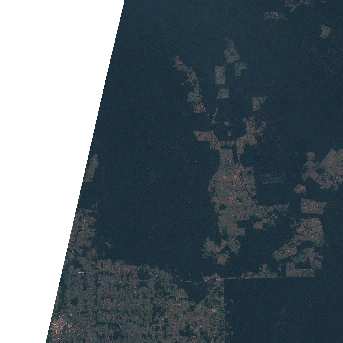

In [118]:
#collect query previes
image_urls = []
for i in query_results['Items']:
    img_url = str(i["Assets"]["thumbnail"]["Href"])
    image_urls.append(img_url)  
#show random sample from previews
img_url = random.sample(image_urls, 1)[0]
print(img_url)
display.Image(img_url)

#### `JobConfig`

We have previously set filters for the satellite imagery to be retrieved. These included geospatial filers (`AreaOfInterest`), time-based filters (`TimeRangeFilter`) and other property filters (`PropertyFilter`) such as cloud cover. In this section we now define the geospatial model that is to be applied to the retrieved images. SageMaker's geospatial capabilities comprise the following pre-implemented models:
* `BandMathConfig` : predefined (`NDVI, EVI2, MSAVI, NDWI, NDMI, NDSI, WDRVI`) or custom bandmath operations
* `ResamplingConfig`: scales the satellite images to a different resolution
* `TemporalStatisticsConfig`: calculates statistics through time for given geotiff
* `CloudRemovalConfig`: pixel-wise statistic operations performed on user-defined regions of a raster satellite imagery
* `ZonalStatisticsConfig`: combines input geotiffs spatially
* `GeoMosaicConfig`: combines input geotiffs spatially
* `StackConfig`: combine bands in separate geotiffs into one geotiff
* `CloudMaskingConfig`: masks clouds from output
* `LandCoverSegmentationConfig`: multi-class classification algorithm that performs land cover segmentation

Please refer to the [documentation](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_geospatial_JobConfigInput.html) for further details.

For our use case we are interested in changes in vegetation, e.g., due to deforestation. We therefore select the `BanddMath` model, which performs pixel-by-pixel mathematical computation operations on the different bands captured by Sentinel 2. A common use case is the computation of vegetation indices.

`BandMath`, as implemented here, computes several types of vegetation indices (NDVI/EVI2/MSAVI2). For our use case we select [Normalized Difference Vegetation Index (NDVI)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index#:~:text=The%20normalized%20difference%20vegetation%20index,observed%20contains%20live%20green%20vegetation). NDVI repesents a common approach for surveying biomes (see e.g., [ Fractional vegetation cover from Sentinel-2](https://sentinel.esa.int/web/success-stories/-/fractional-vegetation-cover-from-sentinel-2) use case). Negative values of NDVI (values approaching -1) correspond to water. Values close to zero (-0.1 to 0.1) generally correspond to barren areas of rock, sand, or snow. Lastly, low, positive values represent shrub and grassland (approximately 0.2 to 0.4), while high values indicate temperate and tropical rainforests (values approaching 1). Below is a map of NDVI and corresponding vegetation type:

```
NDVI_map={(-1.0,0.0]: "no vegetation (water, rock, artificial structures)",
          (0.0,0.5]: "light vegetation (shrubs, grass, fields)",
          (0.5,0.7]: "dense vegetation (forests, plantations)",
          (0.7,1.0]: "very dense vegetation (rainforest)"}
```


Below we set the `JobConfig` for the `BandMath` model.

In [119]:
job_config={
        "BandMathConfig": {
           'PredefinedIndices': [
                'NDVI',
            ]
        },
    }

___

<a id='execute_eoj'></a>
## Execute Earth Observation Job (EOJ)

Having defined query parameters and EOJ job cinfigurations, we are now in a position to start the EOJ. To do so, we call `sm_geo_client.start_earth_observation_job()`. This creates an Earth Observation Job (EOJ), which will be run in the background on AWS-managed servers.

In [120]:
# additional settings
job_name = "EOJ-{}-{}-{}-{}".format(out_dict["supplier_name"], out_dict["AOI_name"],out_dict["year"],out_dict["quarter"]) #cannot have underscores, use AWS naming convention!
#input config
input_config=query_param
input_config["RasterDataCollectionArn"] = data_collection_arn #add RasterDataCollectionArn to input_conf
#output config
save_conf = {"S3OutputPath": "s3://{}".format(main_bucket_name)+"/raw-eoj-output/"}

In [121]:
#invoke EOJ this will run in the background for several minutes
eoj = sm_geo_client.start_earth_observation_job(
    Name=job_name,
    ExecutionRoleArn=sm_exec_role,
    InputConfig={"RasterDataCollectionQuery":input_config},
    JobConfig=job_config)
print("EOJ started with... \nName: {} \nID: {}".format(eoj["Name"],eoj["Arn"]))
#add metadata to output json
out_dict["eoj_id"] = eoj["Arn"]
out_dict["eoj_config"] = {"InputConfig":input_config,
                          "EarthObservationJobConfig":job_config}
#write EOJ metadata and config to bucket
prefix = "processed-eoj-output/{}/{}/{}-{}/".format(out_dict["supplier_name"],out_dict["AOI_name"],out_dict["year"],out_dict["quarter"])
s3object = s3.Object(out_dict["main_bucket_name"], '{}eoj_metadata.json'.format(prefix))
s3object.put(Body=(bytes(json.dumps(out_dict).encode('UTF-8'))));

EOJ started with... 
Name: EOJ-brazil-farmer-brazil-mato-grosso-2017-Q3 
ID: arn:aws:sagemaker-geospatial:us-west-2:659424347583:earth-observation-job/25ndgvbw2abi


Below we list some key EOJ parameters by querying the API

In [128]:
#display status on other metadata
resp= sm_geo_client.get_earth_observation_job(Arn=eoj["Arn"])
print("EOJ Name:", resp["Name"])
print("EOJ Status:", resp["Status"])

EOJ Name: EOJ-brazil-farmer-brazil-mato-grosso-2017-Q3
EOJ Status: COMPLETED


Once the EOJ has completed we can visualize it using the [built-in FourSquare Studio functionality](https://docs.aws.amazon.com/sagemaker/latest/dg/geospatial-visualize.html). To do so, we first render the map, and then modify it by adding layers for AOI, input and output.

In [130]:
#initialize and render map
geo_map = sagemaker_geospatial_map.create_map({"is_raster": True})
geo_map.set_sagemaker_geospatial_client(sm_geo_client)
geo_map.render()

SyncWidgetMap(raster={'stacSearchUrl': AnyHttpUrl('https://domain-name/raster', )}, style={'height': '100%', '…

We first review the AOI layer again (i.e., the bounding box)

In [132]:
#Add AOI Layer
config = {"label": "EOJ AOI"}
aoi_layer = geo_map.visualize_eoj_aoi(
    Arn=eoj["Arn"], 
    config=config
)

We then review the input raster image (prior to performing the `BandMath` operation). This Layer will be rendered in the above map.

In [125]:
#Add Input Layer
config = {"label": "EOJ Input"}
input_layer = geo_map.visualize_eoj_input(
    Arn=eoj["Arn"], config=config
)

Finally, we can review the output of the EOJ.
> Note that the EOJ needs to be in "COMPLETED" status before it can be rendered.

In [133]:
#Add Output Layer
config = {
    "label":"EOJ Output",
    "preset": "singleBand",
    "band_name": "ndvi"
}
input_layer = geo_map.visualize_eoj_output(
    Arn=eoj["Arn"], config=config
)

#### Running quarterly EOJs (and optionally creating a history of EOJs)

We now package the above routine into a single function/cell. It will usually be sufficient to retrieve updates every month or quarter to be able to assess changes in vegetation. The below function implements a quarterly EOJ run which can iteratively relax limits on e.g., cloud cover in case insufficient results are returned. Note that there is a trade-off between temporal resolution and the amount of usabel (i.e., cloud-free) satellite imagery returned by the EOJ. Depending on the location it may be necessary to widen the search window (i.e., accept a lower temporal resolution). This must be carefully tuned to the respective use case.

Note that the below function can also be used to generate a history of EOJs if this is required by looping over the desired set of periods (e.g., quarters, months, weeks). Note that service quotas may require you to implement a status checker that will periodically check the number of concurrent jobs and only initiatiate new jobs as long as the service quota is not exceeded.

In [82]:
def run_eoj_quarterly(quarter_start,quarter_end,out_dict_init,data_collection_arn,input_config,job_config,exec_role_arn):
    """
    Summary routine that runs an EOJ for a given set of parameters.
    """
    #initialize and update out_dict
    quarter_start_map={"01":"Q1","04":"Q2","07":"Q3","10":"Q4"}
    out_dict = out_dict_init
    out_dict["year"] = quarter_start.split("-")[0]   
    out_dict["month"] = quarter_start.split("-")[1]
    out_dict["quarter"] = quarter_start_map[quarter_start.split("-")[1]]
    out_dict["week"] = "n/a" #we do not use weekly res for now
    #initialize query parameter
    query_param = input_config
    query_param.pop("RasterDataCollectionArn") #not needed here
    #update time filter to provided date   
    query_param['TimeRangeFilter']['StartTime'] = '{}-01T00:00:00'.format(quarter_start)
    query_param['TimeRangeFilter']['EndTime'] = '{}-30T00:00:00'.format(quarter_end)
    #find optimum cloud cover setting (lowest possible to ensure clear view)
    max_cloud_cover = 0 #initialize
    result_count = 0 #initialize
    while result_count<1:
        #update cloud cover param
        query_param["PropertyFilters"]["Properties"][0]["Property"]["EoCloudCover"]["UpperBound"] = max_cloud_cover
        #run
        query_results = sm_geo_client.search_raster_data_collection(Arn = data_collection_arn, RasterDataCollectionQuery = query_param)
        #update iterators
        result_count=query_results["ApproximateResultCount"]
        max_cloud_cover+=1
    print("Number of images returned by query: {} (at max. cloud cover of {})".format(result_count,max_cloud_cover))
    #start EOJ
    job_name = "EOJ-{}-{}-{}-{}".format(out_dict["supplier_name"], out_dict["AOI_name"], out_dict["year"],out_dict["quarter"])
    #re-set input config
    input_config=query_param
    input_config["RasterDataCollectionArn"] = data_collection_arn #add RasterDataCollectionArn to input_conf
    print(input_config)
    eoj = sm_geo_client.start_earth_observation_job(Name=job_name,
                                                    InputConfig={"RasterDataCollectionQuery":input_config},
                                                    JobConfig=job_config)
    #add metadata to output json
    out_dict["eoj_id"] = eoj["Arn"]
    out_dict["eoj_config"] = {"InputConfig":input_config,"EarthObservationJobConfig":job_config}
    #write EOJ metadata and config to bucket
    prefix = "processed-eoj-output/{}/{}/{}-{}/".format(out_dict["supplier_name"],out_dict["AOI_name"],out_dict["year"],out_dict["quarter"])
    s3object = s3.Object(out_dict["main_bucket_name"], '{}eoj_metadata.json'.format(prefix))
    s3object.put(Body=(bytes(json.dumps(out_dict).encode('UTF-8'))));
    
    print(f"EOJ metadata stored in S3 with following prefix: {prefix}")
    return eoj["Arn"]

In [83]:
quarter_start="2022-07" #YYYY-MM
quarter_end="2022-09" #YYYY-MM
eoj_id = run_eoj_quarterly(quarter_start=quarter_start, quarter_end=quarter_end, out_dict_init=out_dict, data_collection_arn=data_collection_arn,
                           input_config=input_config,job_config=job_config,exec_role_arn=sm_exec_role)

Number of images returned by query: 7 (at max. cloud cover of 2)
{'AreaOfInterest': {'AreaOfInterestGeometry': {'PolygonGeometry': {'Coordinates': [[[-61.47502802133589, -10.547903668545445], [-61.47502802133589, -10.749253483741057], [-61.17444254239267, -10.749253483741057], [-61.17444254239267, -10.547903668545445], [-61.47502802133589, -10.547903668545445]]]}}}, 'TimeRangeFilter': {'StartTime': '2022-07-01T00:00:00', 'EndTime': '2022-09-30T00:00:00'}, 'PropertyFilters': {'Properties': [{'Property': {'EoCloudCover': {'LowerBound': 0, 'UpperBound': 1}}}], 'LogicalOperator': 'AND'}, 'RasterDataCollectionArn': 'arn:aws:sagemaker-geospatial:us-west-2:378778860802:raster-data-collection/public/nmqj48dcu3g7ayw8'}
EOJ metadata stored in S3 with following prefix: processed-eoj-output/brazil-farmer/brazil-mato-grosso/2022-Q3/


In [84]:
#display status on other metadata
resp= sm_geo_client.get_earth_observation_job(Arn=eoj_id)
print("EOJ Name:", resp["Name"])
print("EOJ Status:", resp["Status"])
print("EOJ Duration (min):", round(resp["DurationInSeconds"]/60,2))

EOJ Name: EOJ-brazil-farmer-brazil-mato-grosso-2022-Q3
EOJ Status: INITIALIZING
EOJ Duration (min): 0.0


EOJ Status Check (Optional): Set the below status checker loop to `active=True` to retrieve regular updates on the EOJ. The routine periodically queries the API for the EOJ status. Note that a typical EOJ takes approx. 20 minutes to complete.

In [85]:
#OPTIONAL STATUS CHECKER, set to active=True
active=True
if active:
    start_time = time.time() #gets start time
    while True:
        current_time = time.time()
        resp= sm_geo_client.get_earth_observation_job(Arn=eoj_id)
        print("EOJ (ID={}) Status: {} (time elapsed [min]: {})".format(eoj_id,resp["Status"], round((current_time-start_time)/60,0)))
        if resp["Status"] == "COMPLETED":
            break

        time.sleep(60*2) #wait for 2 min until next status check

EOJ (ID=arn:aws:sagemaker-geospatial:us-west-2:659424347583:earth-observation-job/rnhwpe6vwbp6) Status: IN_PROGRESS (time elapsed [min]: 0.0)
EOJ (ID=arn:aws:sagemaker-geospatial:us-west-2:659424347583:earth-observation-job/rnhwpe6vwbp6) Status: IN_PROGRESS (time elapsed [min]: 2.0)
EOJ (ID=arn:aws:sagemaker-geospatial:us-west-2:659424347583:earth-observation-job/rnhwpe6vwbp6) Status: IN_PROGRESS (time elapsed [min]: 4.0)
EOJ (ID=arn:aws:sagemaker-geospatial:us-west-2:659424347583:earth-observation-job/rnhwpe6vwbp6) Status: IN_PROGRESS (time elapsed [min]: 6.0)
EOJ (ID=arn:aws:sagemaker-geospatial:us-west-2:659424347583:earth-observation-job/rnhwpe6vwbp6) Status: IN_PROGRESS (time elapsed [min]: 8.0)
EOJ (ID=arn:aws:sagemaker-geospatial:us-west-2:659424347583:earth-observation-job/rnhwpe6vwbp6) Status: IN_PROGRESS (time elapsed [min]: 10.0)
EOJ (ID=arn:aws:sagemaker-geospatial:us-west-2:659424347583:earth-observation-job/rnhwpe6vwbp6) Status: IN_PROGRESS (time elapsed [min]: 12.0)
EOJ 

Note: As an extension to the above procedure, you may consider the following:
* Run a `CloudRemoval`job on the query results first, and the do the `BandMath` job.
* Orchestrate the EOJs by using [SageMaker Pipelines](https://aws.amazon.com/sagemaker/pipelines/).

___

<a id='retrieve_eoj'></a>
## Retrieve Earth Observation Job (EOJ) Output

#### Set parameters for EOJ on scope and retrieve EOJ metadata

In [72]:
#clear/initialize out_dict
out_dict={} #this will collect main dataset
barchart_df=pd.DataFrame() #this will collect dataset for distributional barcharts
#set parameters for EOJ that needs to be retrieved
year = '2017'
quarter = 'Q3'
year_quarter =  f"{year}-{quarter}"
quarter_month_map={"Q1":1,"Q2":4,"Q3":7,"Q4":10}
year_month_dt =  datetime(year=int(year), month=quarter_month_map[quarter],day=1).isoformat()
baseline_spec = {"supplier_name":supplier_name,"AOI_name":aoi_name,"year":"2017", "quarter":"Q3"}
baseline_year_quarter =  "{}-{}".format(baseline_spec["year"],baseline_spec["quarter"])
prefix_main = "processed-eoj-output/main-data/{}/{}/{}-{}/".format(supplier_name,aoi_name,year,quarter)
prefix_barchart = "processed-eoj-output/barchart-data/{}/{}/{}-{}/".format(supplier_name,aoi_name,year,quarter)
prefix_img = "processed-eoj-output/img-data/{}/{}/{}-{}/".format(supplier_name,aoi_name,year,quarter)
#retrieve eoj config results and match to output
s3object = s3.Object(main_bucket_name, '{}eoj_metadata.json'.format("processed-eoj-output/{}/{}/{}-{}/".format(supplier_name,aoi_name,year,quarter)))
body = s3object.get()['Body'].read().decode()
out_dict = json.loads(body)
#add data to output
out_dict['main_bucket_name'] = main_bucket_name #make sure buckets are intialized
out_dict['img_bucket_name'] = img_bucket_name #make sure buckets are intialized
out_dict["year"] = year
out_dict["quarter"] = quarter
out_dict["year_quarter"] = year_quarter
out_dict["baseline_year_quarter"] = baseline_year_quarter
out_dict["year_month_dt"] = year_month_dt
out_dict["file_prefix_main"] = prefix_main
out_dict["file_prefix_barchart"] = prefix_barchart
out_dict["file_prefix_img"] = prefix_img

#### Export EOJ to S3

First, we export the EOJ to the target S3 bucket. EOJ outputs will be saved at the following S3 location: `s3://<main_bucket_name>/raw-eoj-output/output/consolidated/`. We retrieve the relevant output files and save them to `/temp` storage on the local EFS for further processing in this notebook. Exporting typically takes 1-2 minutes.

In [73]:
export_job=sm_geo_client.export_earth_observation_job(
    Arn=out_dict["eoj_id"],
    ExecutionRoleArn=sm_exec_role,
    OutputConfig={"S3Data": {"S3Uri":"s3://{}".format(main_bucket_name)+"/raw-eoj-output/"}}
)

In [74]:
#OPTIONAL Export Job STATUS CHECKER, set to active=True
active=True
if active:
    start_time = time.time() #gets start time
    while True:
        current_time = time.time()
        resp = sm_geo_client.get_earth_observation_job(Arn=out_dict["eoj_id"])
        print("Export Job (ID={}) Status: {} (time elapsed [min]: {})".format(resp["Arn"],resp["ExportStatus"], round((current_time-start_time)/60,0)))
        if resp["ExportStatus"] == "SUCCEEDED":
            break
        time.sleep(10) #wait for 10s until next status check

Export Job (ID=arn:aws:sagemaker-geospatial:us-west-2:659424347583:earth-observation-job/t5ku6zsnndvx) Status: IN_PROGRESS (time elapsed [min]: 0.0)
Export Job (ID=arn:aws:sagemaker-geospatial:us-west-2:659424347583:earth-observation-job/t5ku6zsnndvx) Status: IN_PROGRESS (time elapsed [min]: 0.0)
Export Job (ID=arn:aws:sagemaker-geospatial:us-west-2:659424347583:earth-observation-job/t5ku6zsnndvx) Status: IN_PROGRESS (time elapsed [min]: 0.0)
Export Job (ID=arn:aws:sagemaker-geospatial:us-west-2:659424347583:earth-observation-job/t5ku6zsnndvx) Status: IN_PROGRESS (time elapsed [min]: 1.0)
Export Job (ID=arn:aws:sagemaker-geospatial:us-west-2:659424347583:earth-observation-job/t5ku6zsnndvx) Status: IN_PROGRESS (time elapsed [min]: 1.0)
Export Job (ID=arn:aws:sagemaker-geospatial:us-west-2:659424347583:earth-observation-job/t5ku6zsnndvx) Status: IN_PROGRESS (time elapsed [min]: 1.0)
Export Job (ID=arn:aws:sagemaker-geospatial:us-west-2:659424347583:earth-observation-job/t5ku6zsnndvx) Sta

#### Download relevant files to local drive
Here we retrieve the relevant output files returned from the EOJ and download them to the local EFS volume for further processing in this notebook

Each EOJ may return observations from different satellites (Sentinel 2A or 2B), different tiles that intersect the AOI (e.g., 11SKB, 10SGG, etc,) and times. This can be readily identified from the file name, which follows the following convention: `<satelliteID>_<tileID>_<date>_0_<productID>_ndvi`.

- `satelliteID`: Sentinel 2 is a 2-satellite constellation consitsing of Sentinel 2A and Sentinel 2B
- `tileID`: Sentinel-2 has a 290 km field of view when capturing its imagery. This imagery is then projected on to a UTM grid and made available publicly on 100x100 km2 tiles. Each tile has a unique ID. This ID scheme allows all imagery for a given tile to be located. See [here](https://eatlas.org.au/data/uuid/f7468d15-12be-4e3f-a246-b2882a324f59) for more details.
- `date`: date at which image was taken (format is YYYYMMDD)
- `productID`: for NDVI we use L2A. Level-2A product provides orthorectified Bottom-Of-Atmosphere (BOA) reflectance, with sub-pixel multispectral registration. A Scene Classification map (cloud, cloud shadows, vegetation, soils/deserts, water, snow, etc.) is included in the product.

In [75]:
# download to local EFS volume
def load_eoj_output(out_dict,bucket_name=main_bucket_name,temp_path=temp_path,output_path=output_path):
    """
    Loads relevant _ndvi.tif files from EOJ s3 output bucket and saves to local drive.
    Neglects all irrelevant output.
    """
    #download files
    keys=[]
    for i in s3_client.list_objects(Bucket=out_dict['main_bucket_name'],Prefix='raw-eoj-output/{}/'.format(out_dict["eoj_id"].split("/")[-1]))["Contents"]:
        if ".tif" in i['Key']: #ensures that only relevant files are downloaded
            keys.append(i['Key'])
    print(len(keys)," files in scope")
    #create destination folder if it does not exist
    if not os.path.exists(output_path+out_dict["file_prefix_main"]):
        ! mkdir {temp_path+out_dict["file_prefix_main"]} -p
    #copy raw data to local drive
    for k in keys:
        if not os.path.isfile(temp_path+out_dict["file_prefix_main"]+k.split("/")[-1]): #check if file already exists
            ! aws s3 cp {"s3://"+bucket_name+"/"+k} {temp_path+out_dict["file_prefix_main"]}
    return [k.split("/")[-1] for k in keys]

In [76]:
filelist = load_eoj_output(out_dict,temp_path=temp_path,output_path=output_path) ## CAUTION: If this cell causes an error, wait a little until the EOJ export has completed

5  files in scope


In [77]:
filelist

['S2B_20LPP_20170707_0_L2A_ndvi.tif',
 'S2A_20LPP_20170712_0_L2A_ndvi.tif',
 'S2B_20LPP_20170727_0_L2A_ndvi.tif',
 'S2B_20LPP_20170905_0_L2A_ndvi.tif',
 'S2B_20LPP_20170925_0_L2A_ndvi.tif']

#### Select subsample from output files

We select up to `len(unique_tiles)` files (for performance reasons) while ensuring all tiles are captured in the selection.

In [58]:
def select_output_subsample(out_dict,filelist,temp_path=temp_path):
    """
    Selects n=len(unique_tiles) samples from retrieved raster 
    images while ensuring all retrieved tiles are represented
    """
    #get unique tiles and dates
    tiles=[]
    dates=[]
    for f in filelist:
        tiles.append(f.split("/")[-1].split("_")[1])
        dates.append(f.split("/")[-1].split("_")[2])
    unique_tiles = list(set(tiles))
    unique_dates  = list(set(dates))
    unique_dates.sort()
    
    #select files
    selected_files = []
    if len(unique_tiles)>1:
        subsamples = dict()
        for t in unique_tiles:
            subsamples[t] = [k for k in filelist if t in k]
            selected_files.append(random.choice(subsamples[t]))
    else: #if just 1 tile in output, select earliest
        subsamples= [k for k in filelist if unique_dates[0] in k]
        selected_files.append(random.choice(subsamples))
    selected_files = [temp_path+out_dict["file_prefix_main"]+f for f in selected_files]
    #write to output
    out_dict["eoj_selected_observation_id"] = selected_files
    #print details
    print("Unique tiles in sample:",unique_tiles)
    print("Unique dates in sample:",unique_dates)
    print("Selected files:",selected_files)
    
    return unique_tiles,unique_dates,selected_files,out_dict

In [59]:
unique_tiles,unique_dates,selected_files,out_dict = select_output_subsample(out_dict,filelist)

Unique tiles in sample: ['20LPP']
Unique dates in sample: ['20170707', '20170712', '20170727', '20170905', '20170925']
Selected files: ['../assets/temp/processed-eoj-output/main-data/brazil-farmer/brazil-mato-grosso/2017-Q3/S2B_20LPP_20170707_0_L2A_ndvi.tif']


___

<a id='process_eoj'></a>
## Process Earth Observation Job (EOJ) Output

Since the AOI may be visible from different tiles, but is not always fully captured in each 100kmx100km tile, we need to combine/merge the retrieved tiles into a single satellite raster image. In order to achieve this, the oordinate reference system (CRS) projection of the tiles must match. Each retrieved raster image from Sentinel 2 carries the CRS information in its meta data. We can therefore reproject each image to a common coordinate reference system (CRS) to allow combination/merging. This is performed by the below function.

In [60]:
def merge_tif_files(out_dict,files_to_merge_paths_dict, output_file_name, preferred_projection=False,output_path=output_path):
    """
    Merges geotiffs contained in `files_to_merge_paths_dict` into single geotiff by ovelaying them. 
    Function automatically aligns CRS projections using `preferred_projection` param.
    Output is saved as .tif to path specified in `out_dict`and using `output_file_name` name
    """
    selected_files = files_to_merge_paths_dict       
    #get CRS projection per each file
    projections = dict()
    for f in selected_files:
        with rasterio.open(f) as src: 
            projections[f] = {"raster_crs": src.profile["crs"]}
    #set dest_crs
    if preferred_projection:
        dst_crs = preferred_projection
    else:
        dst_crs = "{}".format(str(projections[selected_files[0]]["raster_crs"]).split("(")[0])
    print("Output will be reprojected to the following CRS: ", dst_crs)
    
    #reproject
    for f in selected_files:
        with rasterio.open(f) as src:
            transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
            kwargs = src.meta.copy()
            kwargs.update({
                'crs': dst_crs,
                'transform': transform,
                'width': width,
                'height': height})
            #with rasterio.open(f.split(".")[1]+"_reproject.tif", 'w', **kwargs) as dst:
            with rasterio.open(f, 'w', **kwargs) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest)
    #update projection info
    for f in selected_files:
        with rasterio.open(f) as src:  #check if files are available on local EFS, else download from S3
            projections[f] = {"raster_crs": src.profile["crs"],"raster_meta":src.meta.copy()}             
    #merge
    out,out_transform = rasterio.merge.merge(selected_files,method='max')
    out_meta_tif = dict(projections[selected_files[0]]["raster_meta"])
    out_meta_tif.update({"height": out.shape[1], "width": out.shape[2],"transform": out_transform})
    #save
    eoj_path_local = output_path+out_dict["file_prefix_img"]
    if not os.path.exists(eoj_path_local):
        ! mkdir {eoj_path_local} -p
    with rasterio.open(eoj_path_local+output_file_name+".tif", "w", **out_meta_tif) as dest:
        dest.write(out[0],1)

In [61]:
merge_tif_files(out_dict=out_dict,
                files_to_merge_paths_dict=selected_files,
                output_file_name="S2_all-tiles")

Output will be reprojected to the following CRS:  EPSG:32720


Plot the result and save as png (for visualization in QuickSight)

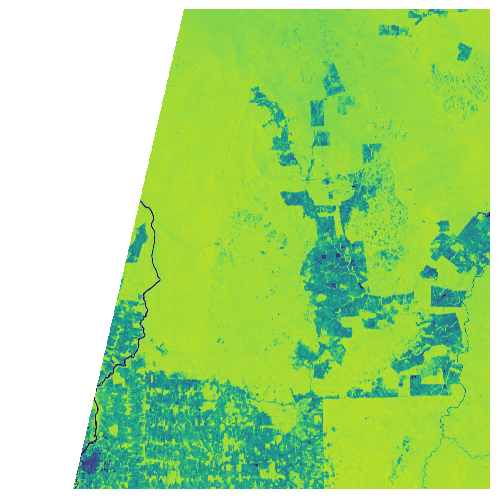

In [62]:
visualize_and_convert_tif_to_png(origin_path=output_path+out_dict["file_prefix_img"], 
                                 tif_file_name="S2_all-tiles", 
                                 destination_path=output_path+out_dict["file_prefix_img"],
                                 vmax=1,vmin=-0,  #vegetation only happens in 0-1 NDVI range, set limits accordingly
                                 cmap="viridis", #use cmap to change to desired colour scheme
                                 supress_output=False) 

#### Clip/Mask to Area of Interest (AOI)

The EOJ returns entire tiles. These need to be clipped to the original AOI. Again, the coordinate reference system (CRS) projections of the merged tile and the AOI must match. The below function implements the reporjection and AOI-masking routine.

In [63]:
def clip_raster_to_aoi(out_dict,output_path=output_path):
    """
    Clips full-sized raster image to AOI and saved output as .png and .tif
    """
    #initialize aoi
    aoi_shape = gpd.read_file(out_dict["AOI_bbox_geojson"])
    aoi_shape = aoi_shape.set_crs(epsg=4326)
    #get raster and merge
    with rasterio.open(output_path+out_dict["file_prefix_img"]+"S2_all-tiles"+".tif") as src:
        target_crs=src.crs
        aoi_proj = aoi_shape.to_crs(src.crs)
        out_image, out_transform = rasterio.mask.mask(src, aoi_proj.geometry,crop=True)
        out_meta_tif = src.meta.copy()
        out_meta_tif.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})
    with rasterio.open(output_path+out_dict["file_prefix_img"]+"ndvi-transformed-sat-img"+".tif", "w", **out_meta_tif) as dest:
        dest.write(out_image)
    out_dict["eoj_selected_observation_crs"] = "{}".format(str(target_crs).split("(")[0])
    
    return out_dict

In [64]:
out_dict=clip_raster_to_aoi(out_dict)

Plot the result and save as png (for visualization in QuickSight)

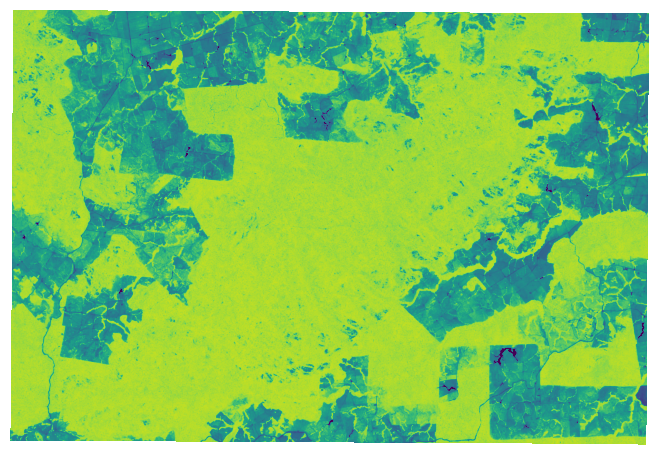

In [65]:
visualize_and_convert_tif_to_png(origin_path=output_path+out_dict["file_prefix_img"], 
                                 tif_file_name="ndvi-transformed-sat-img", 
                                 destination_path=output_path+out_dict["file_prefix_img"],
                                 vmax=1,vmin=-0,  #vegetation only happens in 0-1 NDVI range
                                 cmap="viridis", #use cmap to change to desired colour scheme 
                                 supress_output=False)

Save prefixes to `out_dict` and upload to s3

In [66]:
raster_file_dict = dict({"eoj_ndvi_full_tiles_raster_geotiff_prefix":"S2_all-tiles.tif","eoj_ndvi_full_tiles_raster_png_prefix":"S2_all-tiles.png",
                         "eoj_visible_band_raster_geotiff_prefix":"visible-band-sat-img.tif","eoj_visible_band_raster_png_prefix":"visible-band-sat-img.png",
                         "eoj_ndvi_raster_geotiff_prefix":"ndvi-transformed-sat-img.tif","eoj_ndvi_raster_png_prefix":"ndvi-transformed-sat-img.png"})
out_dict = save_rasters_to_s3(bucket_name=img_bucket_name,raster_file_dict=raster_file_dict,out_dict=out_dict)

Files uploaded ... ['processed-eoj-output/img-data/brazil-farmer/brazil-mato-grosso/2017-Q3/S2_all-tiles.tif', 'processed-eoj-output/img-data/brazil-farmer/brazil-mato-grosso/2017-Q3/S2_all-tiles.png', 'processed-eoj-output/img-data/brazil-farmer/brazil-mato-grosso/2017-Q3/ndvi-transformed-sat-img.tif', 'processed-eoj-output/img-data/brazil-farmer/brazil-mato-grosso/2017-Q3/ndvi-transformed-sat-img.png']


___

<a id='compute_kpis'></a>
## Compute Vegetation KPIs and Anomalies

#### Get Distribution of Raster Values

We first compute avg. and distributional NDVI values for the EOJ (i.e., month) in scope.

In [67]:
def compute_avg_and_distributional_ndvi(out_dict,output_path=output_path):
    """
    Computes avg. and full discrete distribution (default is 40 bins) 
    of NDVI raster values in AOI
    """
    masked_raster_image = rasterio.open(output_path+out_dict["file_prefix_img"]+"ndvi-transformed-sat-img"+".tif")
    #get array of digital numbers (DNS) from raster file
    DNs = masked_raster_image.read(1)#.shape
    NDVI_values = pd.DataFrame(DNs.reshape(DNs.shape[0]*DNs.shape[1],1))
    NDVI_values.dropna(inplace=True)
    NDVI_values.reset_index(inplace=True)
    NDVI_values.columns = ["raster_id","ndvi"]
    #enforce upper and lower limits for binning by adding a max and min dummy rows
    df2 = pd.DataFrame({'raster_id': [9999999999],'ndvi' : -1})
    df3 = pd.DataFrame({'raster_id': [9999999998],'ndvi' : 1})
    NDVI_values = pd.concat([NDVI_values,df2, df3])
    #create discrete bins
    NDVI_values["ndvi_bin"],bins = pd.cut(x=NDVI_values["ndvi"],bins=40,include_lowest=False,right=True,retbins=True,precision=2)
    #remove dummy rows
    NDVI_values = NDVI_values[NDVI_values["raster_id"].isin([9999999999,9999999998])==False]
    #groupby bins
    NDVI_values_abs = NDVI_values.groupby("ndvi_bin").count()#["ndvi"]
    NDVI_values_abs.reset_index(inplace=True)
    NDVI_values_abs.drop(columns="raster_id",inplace=True)
    NDVI_values_abs.rename(columns={"ndvi":"value"},inplace=True)
    #create df for distributional data
    NDVI_values_abs["type"] = "eoj_ndvi_full_discrete_distribution_abs_frequency"
    NDVI_values_abs["bucket"] = NDVI_values_abs["ndvi_bin"].apply(lambda x: x.right)
    NDVI_values_abs["ndvi_bin"] = NDVI_values_abs["ndvi_bin"].apply(lambda x: str(x))
    NDVI_values_abs["supplier_name"] = out_dict["supplier_name"]
    NDVI_values_abs["AOI_name"]= out_dict["AOI_name"]
    NDVI_values_abs["year_quarter"]= out_dict["year_quarter"]
    NDVI_values_rel = NDVI_values_abs.copy()
    NDVI_values_rel["type"] = "eoj_ndvi_full_discrete_distribution_rel_frequency"
    raster_count = NDVI_values_abs["value"].sum()
    NDVI_values_rel["value"] = NDVI_values_rel["value"]/raster_count
    #append
    NDVI_values_eoj = NDVI_values_abs.append(NDVI_values_rel)
    NDVI_values_eoj = NDVI_values_eoj.append({'supplier_name':out_dict["supplier_name"], 'AOI_name':out_dict["AOI_name"], 'year_quarter':out_dict["AOI_name"], 
                                              'bucket':np.nan, 'ndvi_bin':np.nan,'type':"eoj_ndvi_avg", 'value':NDVI_values["ndvi"].mean()},ignore_index=True)
    #add output to output_dict
    out_dict["eoj_ndvi_avg"] = NDVI_values["ndvi"].mean()
    return out_dict, NDVI_values_eoj

In [68]:
out_dict,ndvi_barchart_df = compute_avg_and_distributional_ndvi(out_dict)

Let's plot the NDVI distribution

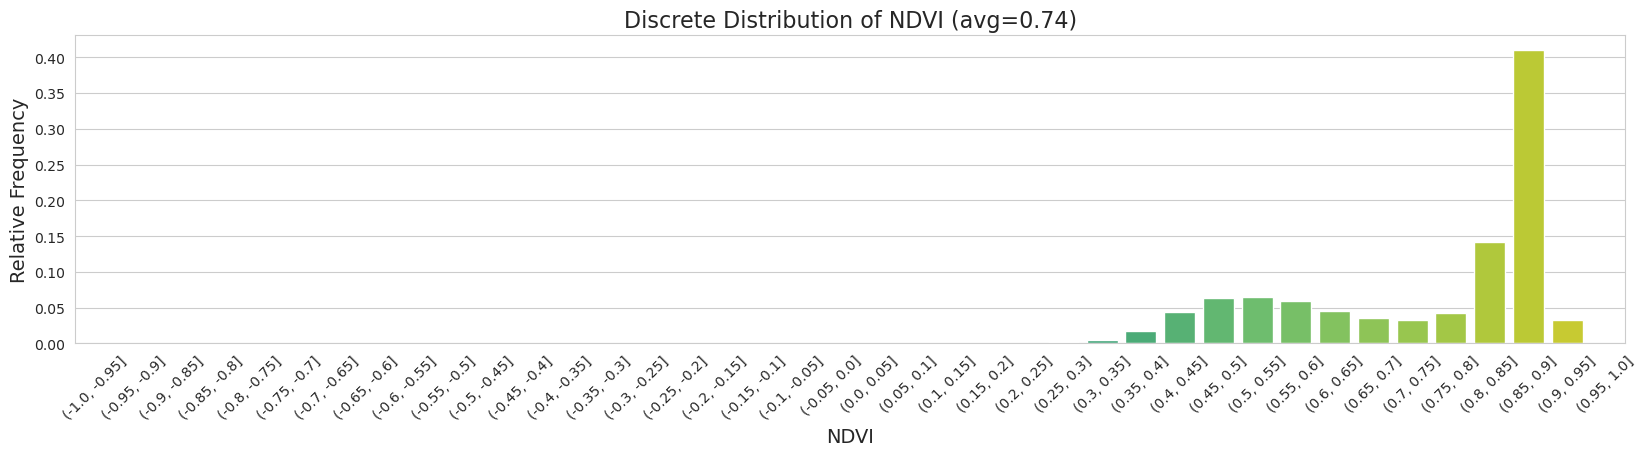

In [69]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(20,4))
sns.barplot(data=ndvi_barchart_df[ndvi_barchart_df["type"]=="eoj_ndvi_full_discrete_distribution_rel_frequency"],x="ndvi_bin",y="value",ax=ax,palette='viridis')
ax.set_ylabel("Relative Frequency",fontsize=14)
ax.set_xlabel("NDVI",fontsize=14)
ax.set_title("Discrete Distribution of NDVI (avg={})".format(round(float(out_dict["eoj_ndvi_avg"]),2)),fontsize=16)
plt.xticks(rotation=45)
plt.show()

### NDVI Anomalies/Changes (vs. Baseline)

#### Parameterize and Retrieve Baseline

Here we load baseline data and add it to the output_dict.

In [70]:
def retrieve_baseline(baseline_spec,out_dict,ndvi_df,bucket_name=main_bucket_name):
    """
    Retrieves baseline NDVI values (avg and distributional) and matches to the output dictionary
    """
    out_dict["baseline_spec"] = baseline_spec
    prefix_baseline_main = "processed-eoj-output/main-data/{}/{}/{}-{}/".format(baseline_spec["supplier_name"],baseline_spec["AOI_name"],baseline_spec["year"],baseline_spec["quarter"])
    prefix_baseline_barchart = "processed-eoj-output/barchart-data/{}/{}/{}-{}/".format(baseline_spec["supplier_name"],baseline_spec["AOI_name"],baseline_spec["year"],baseline_spec["quarter"])
    if not (out_dict["year"] ==  baseline_spec["year"] and out_dict["quarter"] ==  baseline_spec["quarter"]):
        #retrieve baseline results and match to output
        s3 = boto3.resource('s3')
        s3object = s3.Object(bucket_name, '{}data_main.json'.format(prefix_baseline_main))
        body = s3object.get()['Body'].read().decode()
        baseline_data = json.loads(body)
        ndvi_df_baseline = wr.s3.read_json(path='s3://{}/{}data_barchart.json'.format(bucket_name,prefix_baseline_barchart),lines=True)
        ndvi_df_baseline["year_quarter"] = out_dict["year_quarter"]
        #match to output
        out_dict["baseline_ndvi_avg"] = baseline_data["eoj_ndvi_avg"]
        out_dict["baseline_visible_band_raster_geotiff_prefix"] =  baseline_data["eoj_visible_band_raster_geotiff_prefix"]
        out_dict["baseline_visible_band_raster_png_prefix"] = baseline_data["eoj_visible_band_raster_png_prefix"]
        out_dict["baseline_ndvi_raster_geotiff_prefix"] = baseline_data["eoj_ndvi_raster_geotiff_prefix"]
        out_dict["baseline_ndvi_raster_png_prefix"] = baseline_data["eoj_ndvi_raster_png_prefix"]
        ndvi_df_base_abs = ndvi_df_baseline[ndvi_df_baseline["type"]=="eoj_ndvi_full_discrete_distribution_abs_frequency"]
        ndvi_df_base_abs["type"] = "baseline_ndvi_full_discrete_distribution_abs_frequency"
        ndvi_df_base_rel = ndvi_df_baseline[ndvi_df_baseline["type"]=="eoj_ndvi_full_discrete_distribution_rel_frequency"]
        ndvi_df_base_rel["type"] = "baseline_ndvi_full_discrete_distribution_rel_frequency"
        ndvi_df = ndvi_df.append(ndvi_df_base_abs)
        ndvi_df = ndvi_df.append(ndvi_df_base_rel)
        print("Baseline values retrieved and matched ...")
    else:
        #match to output
        out_dict["baseline_ndvi_avg"] = out_dict["eoj_ndvi_avg"]
        out_dict["baseline_visible_band_raster_geotiff_prefix"] =  out_dict["eoj_visible_band_raster_geotiff_prefix"]
        out_dict["baseline_visible_band_raster_png_prefix"] = out_dict["eoj_visible_band_raster_png_prefix"]
        out_dict["baseline_ndvi_raster_geotiff_prefix"] = out_dict["eoj_ndvi_raster_geotiff_prefix"]
        out_dict["baseline_ndvi_raster_png_prefix"] = out_dict["eoj_ndvi_raster_png_prefix"]
        #also add to dataframe
        ndvi_df_base_abs = ndvi_df[ndvi_df["type"]=="eoj_ndvi_full_discrete_distribution_abs_frequency"]
        ndvi_df_base_abs["type"] = "baseline_ndvi_full_discrete_distribution_abs_frequency"
        ndvi_df_base_rel = ndvi_df[ndvi_df["type"]=="eoj_ndvi_full_discrete_distribution_rel_frequency"]
        ndvi_df_base_rel["type"] = "baseline_ndvi_full_discrete_distribution_rel_frequency"
        ndvi_df = ndvi_df.append(ndvi_df_base_abs)
        ndvi_df = ndvi_df.append(ndvi_df_base_rel)
        print("This is the baseline. No baseline values to retrieve. Setting baseline to current values ...")
        
    ndvi_df.reset_index(inplace=True,drop=True)
    return out_dict,ndvi_df

In [71]:
out_dict,ndvi_barchart_df = retrieve_baseline(baseline_spec,out_dict,ndvi_barchart_df)

This is the baseline. No baseline values to retrieve. Setting baseline to current values ...


#### Compute Avg. and Distributional Anomalies

Here we compute the changes (i.e., anomalies vs. the baseline) for both the avg. NDVI and across the NDVI distribution (i.e., bucket-by-bucket differences)

In [72]:
def normalize_and_compute_anomalies(out_dict,ndvi_df):
    """
    Normalizes NDVI values against baseline (100 datum) and computes 
    absolute anomalies of avg and distributional values
    """
    #column-wise
    #normalize
    out_dict["eoj_ndvi_avg_normalized"] = out_dict["eoj_ndvi_avg"]/out_dict["baseline_ndvi_avg"]*100
    #avg anomaly
    out_dict["eoj_ndvi_avg_anomaly"] = out_dict["eoj_ndvi_avg"] - out_dict["baseline_ndvi_avg"]
    #%-change
    out_dict["eoj_ndvi_avg_anomaly_perc"] = (out_dict["eoj_ndvi_avg"] - out_dict["baseline_ndvi_avg"])/out_dict["baseline_ndvi_avg"]
    
    #distributional anomalies(row-wise)
    ndvi_df.sort_values(by=["type","bucket"],inplace=True) #ensure correct order
    ndvi_df_anom_abs = ndvi_df[ndvi_df["type"]=="eoj_ndvi_full_discrete_distribution_abs_frequency"].reset_index(drop=True)
    ndvi_df_anom_abs["type"] = "eoj_ndvi_full_discrete_distribution_abs_anomalies"
    ndvi_df_anom_abs["value"] = (ndvi_df[ndvi_df["type"]=="eoj_ndvi_full_discrete_distribution_abs_frequency"]["value"].reset_index(drop=True) - ndvi_df[ndvi_df["type"]=="baseline_ndvi_full_discrete_distribution_abs_frequency"]["value"].reset_index(drop=True))#.drop(columns="index")

    ndvi_df_anom_rel = ndvi_df[ndvi_df["type"]=="eoj_ndvi_full_discrete_distribution_rel_frequency"].reset_index(drop=True)
    ndvi_df_anom_rel["type"] = "eoj_ndvi_full_discrete_distribution_rel_anomalies"
    ndvi_df_anom_rel["value"] = (ndvi_df[ndvi_df["type"]=="eoj_ndvi_full_discrete_distribution_rel_frequency"]["value"].reset_index(drop=True) - ndvi_df[ndvi_df["type"]=="baseline_ndvi_full_discrete_distribution_rel_frequency"]["value"].reset_index(drop=True))#.drop(columns="index")

    ndvi_df = ndvi_df.append(ndvi_df_anom_abs)
    ndvi_df = ndvi_df.append(ndvi_df_anom_rel)
    ndvi_df = ndvi_df.reset_index(drop=True)
    
    return out_dict,ndvi_df

In [73]:
out_dict,ndvi_barchart_df = normalize_and_compute_anomalies(out_dict,ndvi_barchart_df)

#### Perform Raster Substraction (Locational Anomalies)

The below function performs a pixel-by-pixel NDVI comparison. This allows us to (1) locate the areas where change has occured and (2) quantify the size of the approx. area where vegetation density has significantly reduced. Note that depending on the size of the AOI and the size of the SageMaker instance, this routine may take a while.

In [74]:
def compute_pixel_by_pixel_anomalies(out_dict,supress_output=True,cmap='RdYlGn',output_path=output_path):
    """
    Computes the anomalies per 10x10m pixel in the current raster file vs the baseline raster file.
    Routine is skipped if provided file is the baseline.
    """
    if not (out_dict["year"] ==  baseline_spec["year"] and out_dict["quarter"] ==  baseline_spec["quarter"]):
        #current eoj raster
        with rasterio.open(output_path+out_dict["eoj_ndvi_raster_geotiff_prefix"]) as src:  #check if files are available on local EFS, else download from S3
            ndvi_raster_profile = src.profile
            ndvi_raster_meta = src.meta
            ndvi_raster = src.read(1)
        #baseline raster
        with rasterio.open(output_path+out_dict["baseline_ndvi_raster_geotiff_prefix"]) as src: #check if files are available on local EFS, else download from S3
            ndvi_raster_baseline_profile = src.profile
            ndvi_raster_baseline_meta = src.meta
            ndvi_raster_baseline = src.read(1)
        #get anomaly via raster substraction
        if ndvi_raster_profile["crs"] == ndvi_raster_baseline_profile["crs"]: #check if correct projection
            #ensure correct size, delete excess
            if ndvi_raster_baseline.shape[0] != ndvi_raster.shape[0]:
                ndvi_raster = np.delete(ndvi_raster, ndvi_raster.shape[0]-ndvi_raster_baseline.shape[0], axis=0)
            if ndvi_raster_baseline.shape[1] != ndvi_raster.shape[1]:
                ndvi_raster = np.delete(ndvi_raster, ndvi_raster.shape[1]-ndvi_raster_baseline.shape[1], axis=1)
            #perform raster substraction
            ndvi_raster_anomaly = ndvi_raster - ndvi_raster_baseline
            #save raster file as Geotiff
            out_meta_tif = ndvi_raster_meta
            out_meta_tif.update({"height": ndvi_raster_anomaly.data.shape[0], "width": ndvi_raster_anomaly.data.shape[1]})
            with rasterio.open(output_path+out_dict["file_prefix_img"]+"/ndvi-anomalies-sat-img"+".tif", "w", **out_meta_tif) as dest:
                dest.write(ndvi_raster_anomaly,1)
            #compute affected area
            gt = ndvi_raster_meta["transform"]
            pixel_size_x = gt[0] #in m
            pixel_size_y =-gt[4] #in m
            pixel_area = pixel_size_x/1000*pixel_size_y/1000 #in km2
            #create joint dataframe
            NDVI_anomaly_values = pd.DataFrame(ndvi_raster_anomaly.reshape(ndvi_raster_anomaly.shape[0]*ndvi_raster_anomaly.shape[1],1))
            NDVI_anomaly_values.columns=["ndvi_anomaly"]
            NDVI_baseline_values = pd.DataFrame(ndvi_raster_baseline.reshape(ndvi_raster_baseline.shape[0]*ndvi_raster_baseline.shape[1],1))
            NDVI_baseline_values.columns=["ndvi_baseline"]
            NDVI_anomaly_values = NDVI_anomaly_values.join(NDVI_baseline_values)
            #compute affected area (looking at positive baseline NDVI values only, i.e., where vegetation was present before!)
            NDVI_anomaly_values["neg_deviation"] = NDVI_anomaly_values.apply(lambda x: 1 if x.ndvi_baseline>0 and x.ndvi_anomaly<= -0.05 else 0,axis=1)
            NDVI_anomaly_values["positive_deviation"] = NDVI_anomaly_values.apply(lambda x: 1 if x.ndvi_baseline>0 and x.ndvi_anomaly>= 0.05 else 0,axis=1)
            #save to output
            out_dict["eoj_ndvi_loss_area"] = NDVI_anomaly_values["neg_deviation"].sum()*pixel_area
            out_dict["eoj_ndvi_gain_area"] = NDVI_anomaly_values["positive_deviation"].sum()*pixel_area
            #plot raster file as png
            visualize_and_convert_tif_to_png(origin_path=output_path+out_dict["file_prefix_img"], 
                                 tif_file_name="ndvi-anomalies-sat-img", 
                                 destination_path=output_path+out_dict["file_prefix_img"],vmin=-0.5,vmax=0.5,cmap=cmap,
                                 supress_output=supress_output)
        else:
            print("CRS DOES NOT MATCH!!!")
    else:
        print("This is the baseline. Skipping routine...")
        
    return out_dict

In [75]:
out_dict = compute_pixel_by_pixel_anomalies(out_dict,cmap='viridis',supress_output=False)

This is the baseline. Skipping routine...


In [76]:
raster_file_dict = dict({"eoj_ndvi_anomaly_raster_geotiff_prefix":"ndvi-anomalies-sat-img.tif","eoj_ndvi_anomaly_raster_png_prefix":"ndvi-anomalies-sat-img.png"})
out_dict = save_rasters_to_s3(bucket_name=img_bucket_name,raster_file_dict=raster_file_dict,out_dict=out_dict)

Files uploaded ... []


<a id='upload'></a>
### Upload Results to Data Lake

Upload `data_main.json` and `data_barchart.json` to the data lake. Downstream ETL processes will make them available for visualization in QuickSight.

In [77]:
#save out_dict with metadata
s3object = s3.Object(main_bucket_name, '{}data_main.json'.format(out_dict["file_prefix_main"]))
s3object.put(Body=(bytes(json.dumps(out_dict).encode('UTF-8'))));
#save ndvi_df with distributional
wr.s3.to_json(df=ndvi_barchart_df,path='s3://{}/{}data_barchart.json'.format(main_bucket_name,out_dict["file_prefix_barchart"]),orient='records',lines=True, date_format='iso');

In [78]:
#also save to local file store for inspection
if not os.path.exists(output_path+prefix_main):
    ! mkdir {output_path+prefix_main} -p
with open(output_path+'{}data_main.json'.format(prefix_main), 'w', encoding='utf-8') as f:
    json.dump(out_dict, f, ensure_ascii=False, indent=4)
if not os.path.exists(output_path+prefix_barchart):
    ! mkdir {output_path+prefix_barchart} -p
with open(output_path+'{}data_barchart.json'.format(out_dict["file_prefix_barchart"]), 'w', encoding='utf-8') as f:
    json.dump(ndvi_barchart_df.to_json(orient='records', lines=True),f)

### Summary EOJ Processing Function

The below function packages the previously developed EOJ processing routine into a single function call for ease of use. This function can also be used to retrospectively generated a history of NDVI data by looping over multiple time periods of interest. Note that for our case, the maximum histroy that can be generated goes back to mid-2017, i.e., the time when Sentinel 2 became fully operational.

In [99]:
def eoj_processing_and_kpi_computation(main_bucket_name,img_bucket_name,supplier_name,aoi_name,year,quarter,baseline_spec,cmap='viridis',output_path=output_path):
    """
    Summary function that implements full EOJ processing routine
    """
    #set parameters
    out_dict={}
    year_quarter =  f"{year}-{quarter}"
    quarter_month_map={"Q1":1,"Q2":4,"Q3":7,"Q4":10}
    year_month_dt =  datetime(year=int(year), month=quarter_month_map[quarter],day=1).isoformat()
    baseline_spec = {"supplier_name":supplier_name,"AOI_name":aoi_name,"year":"2017", "quarter":"Q3"}
    baseline_year_quarter =  "{}-{}".format(baseline_spec["year"],baseline_spec["quarter"])
    prefix_main = "processed-eoj-output/main-data/{}/{}/{}-{}/".format(supplier_name,aoi_name,year,quarter)
    prefix_barchart = "processed-eoj-output/barchart-data/{}/{}/{}-{}/".format(supplier_name,aoi_name,year,quarter)
    prefix_img = "processed-eoj-output/img-data/{}/{}/{}-{}/".format(supplier_name,aoi_name,year,quarter)
    #retrieve eoj config results and match to output
    s3object = s3.Object(main_bucket_name, '{}eoj_metadata.json'.format("processed-eoj-output/{}/{}/{}-{}/".format(supplier_name,aoi_name,year,quarter)))
    body = s3object.get()['Body'].read().decode()
    out_dict = json.loads(body)
    out_dict['main_bucket_name'] = main_bucket_name #make sure buckets are intialized
    out_dict['img_bucket_name'] = img_bucket_name #make sure buckets are intialized
    out_dict["year"] = year
    out_dict["quarter"] = quarter
    out_dict["year_quarter"] = year_quarter
    out_dict["baseline_year_quarter"] = baseline_year_quarter
    out_dict["year_month_dt"] = year_month_dt
    out_dict["file_prefix_main"] = prefix_main
    out_dict["file_prefix_barchart"] = prefix_barchart
    out_dict["file_prefix_img"] = prefix_img
    #export eoj
    sm_geo_client.export_earth_observation_job(Arn=out_dict["eoj_id"],ExecutionRoleArn=sm_exec_role,OutputConfig={"S3Data": {"S3Uri":"s3://{}".format(main_bucket_name)+"/raw-eoj-output/"}})
    #wait until ExportStatus == "SUCCEEDED"
    while True:
        resp = sm_geo_client.get_earth_observation_job(Arn=out_dict["eoj_id"])
        if resp["ExportStatus"] == "SUCCEEDED":
            print("Export Job (ID={}) Status: {}".format(resp["Arn"],resp["ExportStatus"]))
            break
        time.sleep(15) #wai until next status check
    #get outputs
    filelist = load_eoj_output(out_dict)
    #get sample
    unique_tiles,unique_dates,selected_files,out_dict = select_output_subsample(out_dict,filelist)
    #merge files, visualize, save and upload to s3
    merge_tif_files(out_dict=out_dict,files_to_merge_paths_dict=selected_files, output_file_name="S2_all-tiles")
    visualize_and_convert_tif_to_png(origin_path=output_path+out_dict["file_prefix_img"],tif_file_name="S2_all-tiles", 
                                     destination_path=output_path+out_dict["file_prefix_img"],vmax=1,vmin=-0,cmap=cmap,supress_output=True) 
    raster_file_dict = dict({"eoj_ndvi_full_tiles_raster_geotiff_prefix":"S2_all-tiles.tif","eoj_ndvi_full_tiles_raster_png_prefix":"S2_all-tiles.png"})
    out_dict = save_rasters_to_s3(bucket_name=img_bucket_name,raster_file_dict=raster_file_dict,out_dict=out_dict)
    #clip raster, visualize, save and upload to s3
    out_dict=clip_raster_to_aoi(out_dict)
    visualize_and_convert_tif_to_png(origin_path=output_path+out_dict["file_prefix_img"],tif_file_name="ndvi-transformed-sat-img",
                                     destination_path=output_path+out_dict["file_prefix_img"],vmax=1,vmin=-0,cmap=cmap,supress_output=True)
    raster_file_dict = dict({"eoj_visible_band_raster_geotiff_prefix":"visible-band-sat-img.tif","eoj_visible_band_raster_png_prefix":"visible-band-sat-img.png",
                             "eoj_ndvi_raster_geotiff_prefix":"ndvi-transformed-sat-img.tif","eoj_ndvi_raster_png_prefix":"ndvi-transformed-sat-img.png"})
    out_dict = save_rasters_to_s3(bucket_name=img_bucket_name,raster_file_dict=raster_file_dict,out_dict=out_dict)
    #compute ndvi avg and dist
    out_dict,ndvi_barchart_df = compute_avg_and_distributional_ndvi(out_dict)
    #retrieve baseline
    out_dict,ndvi_barchart_df = retrieve_baseline(baseline_spec,out_dict,ndvi_barchart_df)
    #get anomalies
    out_dict,ndvi_barchart_df = normalize_and_compute_anomalies(out_dict,ndvi_barchart_df)
    #get pixel-by-pixel anomalies, visualize, save and upload to s3
    out_dict = compute_pixel_by_pixel_anomalies(out_dict,cmap=cmap,supress_output=True)
    raster_file_dict = dict({"eoj_ndvi_anomaly_raster_geotiff_prefix":"ndvi-anomalies-sat-img.tif","eoj_ndvi_anomaly_raster_png_prefix":"ndvi-anomalies-sat-img.png"})
    out_dict = save_rasters_to_s3(bucket_name=img_bucket_name,raster_file_dict=raster_file_dict,out_dict=out_dict)
    #upload
    s3object = s3.Object(main_bucket_name, '{}data_main.json'.format(out_dict["file_prefix_main"]))
    s3object.put(Body=(bytes(json.dumps(out_dict).encode('UTF-8'))));
    #save ndvi_df with distributional
    wr.s3.to_json(df=ndvi_barchart_df,path='s3://{}/{}data_barchart.json'.format(main_bucket_name,out_dict["file_prefix_barchart"]),orient='records',lines=True, date_format='iso');
    #also save to local file store for inspection (outcomment if not desired)
    if not os.path.exists(output_path+prefix_main):
        ! mkdir {output_path+prefix_main} -p
    with open(output_path+'{}data_main.json'.format(prefix_main), 'w', encoding='utf-8') as f:
        json.dump(out_dict, f, ensure_ascii=False, indent=4)
    if not os.path.exists(output_path+prefix_barchart):
        ! mkdir {output_path+prefix_barchart} -p
    with open(output_path+'{}data_barchart.json'.format(out_dict["file_prefix_barchart"]), 'w', encoding='utf-8') as f:
        json.dump(ndvi_barchart_df.to_json(orient='records', lines=True),f)
        
    return out_dict,ndvi_barchart_df

Let us use this processing function to process an EOJ for the most recent data timeframe (2022, Q3). This routine will run for approximately 5 minutes.

In [100]:
year = "2022"
quarter = "Q3"
baseline_spec = {"supplier_name":supplier_name,"AOI_name":aoi_name,"year":"2017", "quarter":"Q3"}
print("Running",year,"-",quarter)
out_dict,ndvi_df = eoj_processing_and_kpi_computation(main_bucket_name=main_bucket_name,
                                                      img_bucket_name = img_bucket_name,
                                                      supplier_name=supplier_name,
                                                      aoi_name=aoi_name,
                                                      year=year,
                                                      quarter=quarter,
                                                      baseline_spec=baseline_spec,
                                                      output_path=output_path)

Running 2022 - Q3
Export Job (ID=arn:aws:sagemaker-geospatial:us-west-2:659424347583:earth-observation-job/rnhwpe6vwbp6) Status: SUCCEEDED
7  files in scope
Unique tiles in sample: ['20LPP']
Unique dates in sample: ['20220701', '20220706', '20220716', '20220721', '20220731', '20220830', '20220909']
Selected files: ['../assets/temp/processed-eoj-output/main-data/brazil-farmer/brazil-mato-grosso/2022-Q3/S2B_20LPP_20220701_0_L2A_ndvi.tif']
Output will be reprojected to the following CRS:  EPSG:32720
Files uploaded ... ['processed-eoj-output/img-data/brazil-farmer/brazil-mato-grosso/2022-Q3/S2_all-tiles.tif', 'processed-eoj-output/img-data/brazil-farmer/brazil-mato-grosso/2022-Q3/S2_all-tiles.png']
Files uploaded ... ['processed-eoj-output/img-data/brazil-farmer/brazil-mato-grosso/2022-Q3/ndvi-transformed-sat-img.tif', 'processed-eoj-output/img-data/brazil-farmer/brazil-mato-grosso/2022-Q3/ndvi-transformed-sat-img.png']
Baseline values retrieved and matched ...
Files uploaded ... ['process

<a id='review'></a>
## Compare Baseline vs. Current NDVI Characteristics

Having computed baseline NDVI characteristics (2017 Q3) and latest vegetation conditions (2022 Q3) across the AOI in scope, we can now compare both conditions side-by-side to review changes. In a production, these visuals would be displayed dynamically in the Amazon QuickSight dashboard. For illustrative purposes, and to verify we perform some visualization here already.

We first look at distributional anomalies in NDVI.

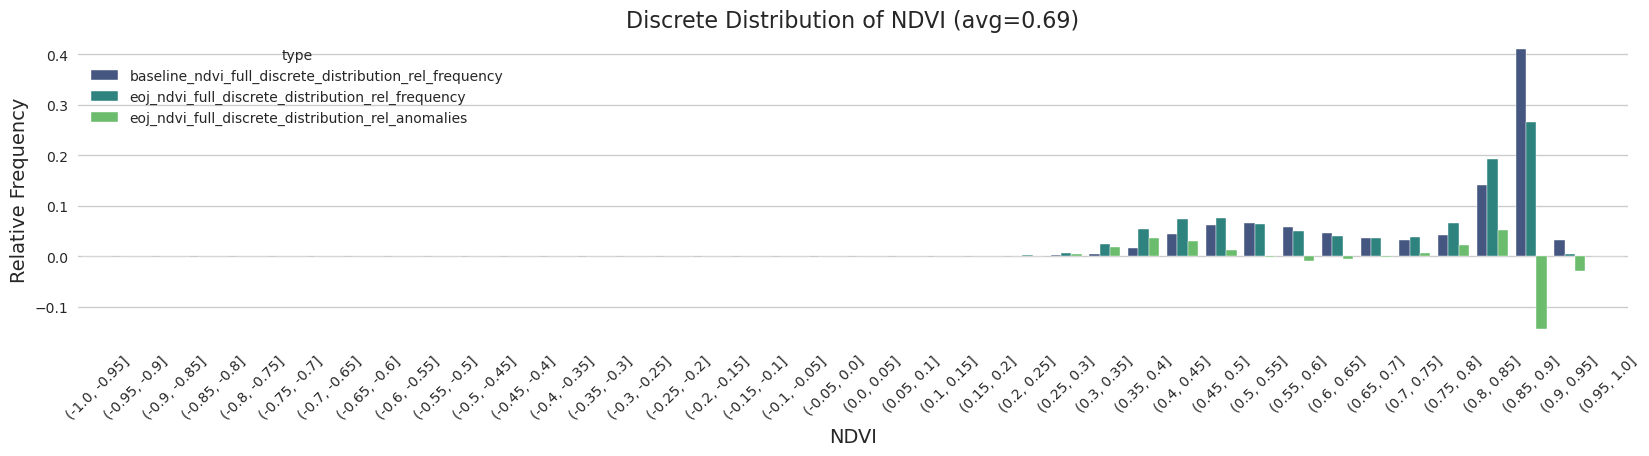

In [101]:
cmap='viridis'
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(20,4))
sns.barplot(data=ndvi_df[ndvi_df["type"].isin(["eoj_ndvi_full_discrete_distribution_rel_frequency","baseline_ndvi_full_discrete_distribution_rel_frequency",
                                               "eoj_ndvi_full_discrete_distribution_rel_anomalies"])==True], x="ndvi_bin",y="value",hue="type",ax=ax,palette=cmap)
ax.set_ylabel("Relative Frequency",fontsize=14)
ax.set_xlabel("NDVI",fontsize=14)
ax.set_title("Discrete Distribution of NDVI (avg={})".format(round(float(out_dict["eoj_ndvi_avg"]),2)),fontsize=16)
plt.xticks(rotation=45)
plt.show()

Finally, let us review the pixel-by-pixel changes in NDVI.

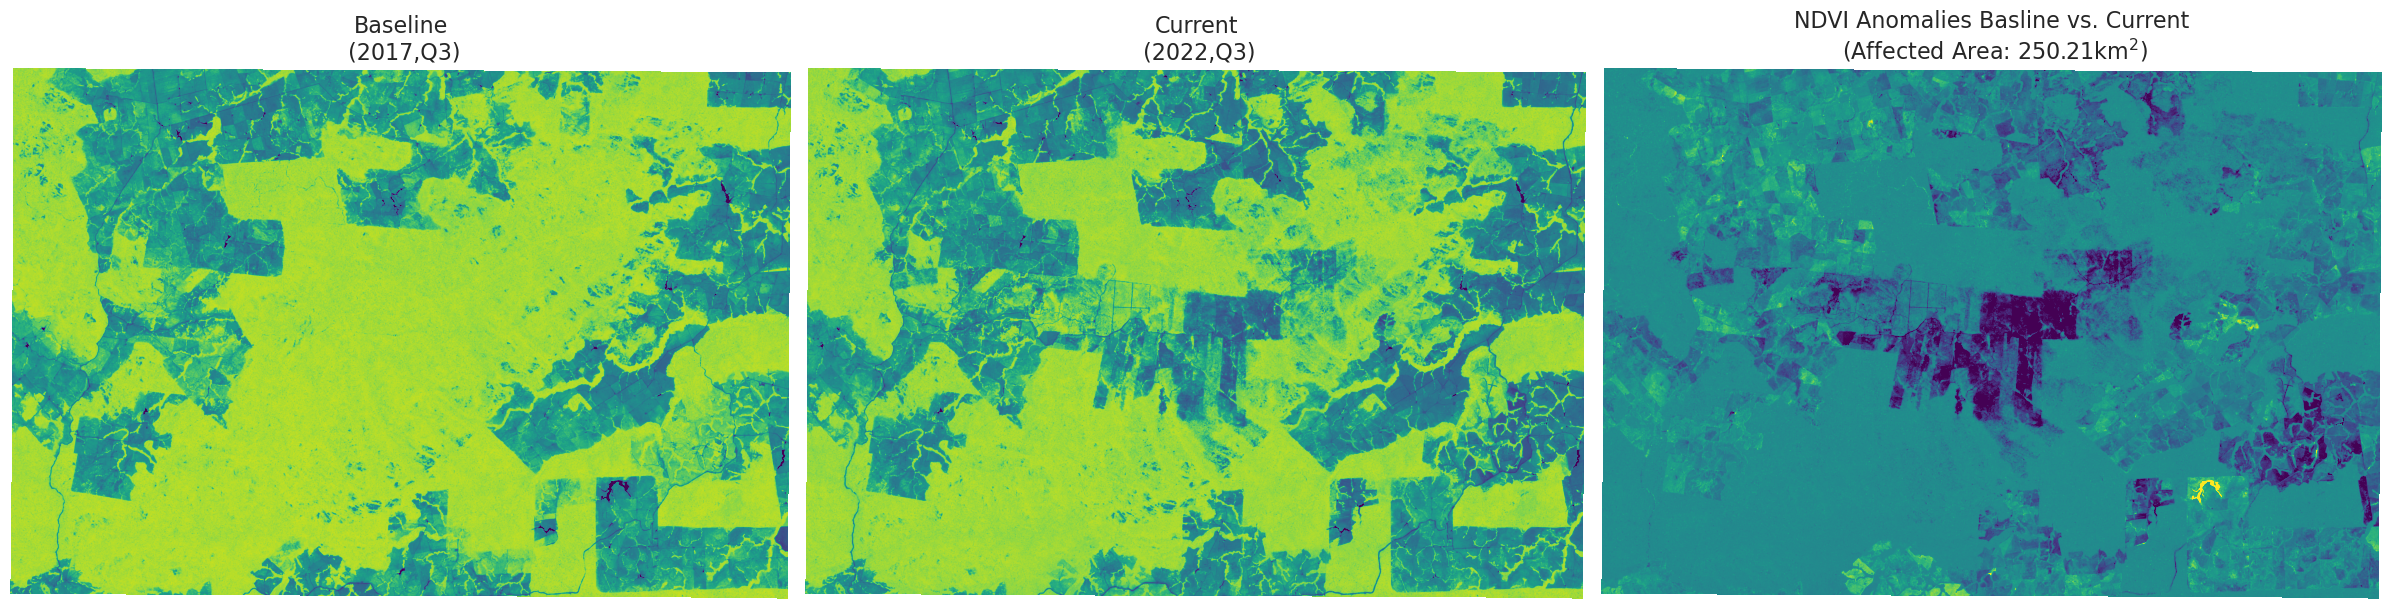

In [102]:
#Visualize .pngs side-by-side
cmap="viridis"
plt.style.use('seaborn')
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(24,14))
#read files
with rasterio.open(output_path+out_dict["baseline_ndvi_raster_geotiff_prefix"]) as src:
    baseline_raster = src.read(1)
with rasterio.open(output_path+out_dict["eoj_ndvi_raster_geotiff_prefix"]) as src:
    ndvi_raster = src.read(1)
with rasterio.open(output_path+out_dict["eoj_ndvi_anomaly_raster_geotiff_prefix"]) as src:
    anomaly_raster = src.read(1)  
#set axes    
axes[0].imshow(np.squeeze(baseline_raster),vmax=1,vmin=-0,cmap=cmap)
axes[0].set_title("Baseline\n ({},{})".format(out_dict["baseline_spec"]["year"],out_dict["baseline_spec"]["quarter"]),fontsize=16)
axes[1].imshow(np.squeeze(ndvi_raster),vmax=1,vmin=-0,cmap=cmap)
axes[1].set_title("Current\n ({},{})".format(out_dict["year"],out_dict["quarter"]),fontsize=16)
axes[2].imshow(np.squeeze(anomaly_raster),vmin=-0.5,vmax=0.5,cmap=cmap)
axes[2].set_title("NDVI Anomalies Basline vs. Current\n (Affected Area: {}km$^2$)".format(round(out_dict["eoj_ndvi_loss_area"],2)),fontsize=16)
#plot
for ax in axes:
    ax.axis("off")
plt.tight_layout(pad=1)
plt.show()

___

End of notebook...